# Analysis of Allergic Rhinitis Gesture Dataset

##### Downloading and Navigating the Dataset

After downloading the [GestureSet Dataset](https://www.kaggle.com/datasets/tzamalisp/gestureset-dataset-for-human-gesture-recognition/data), navigate to the `GestureSet\allergic_rhinitis` directory. This directory contains all the relevant data files and subdirectories for the dataset.

#### Setting Up Data Paths in Your Project

For setting up the data paths in your project, use the following directories:

1. **Training Data Path**:
   - Navigate to the `GestureSet\allergic_rhinitis\gestures_pure_ctrl` directory.
   - This directory should be used as the `TRAINING_DATA_PATH` in your project. It contains the primary dataset used for training models.

2. **Batch Evaluation Data Path**:
   - Navigate to the `GestureSet\allergic_rhinitis\performance_evaluation` directory.
   - Set this path as your `BATCH_EVALUATION_DATA_PATH`. This directory is  for evaluating the performance of your models in a pilot scenario from a batch of data.


## Introduction

This notebook tutorial presents an end-to-end analysis of the Allergic Rhinitis Gesture Dataset, a collection of gesture data pertinent to allergic rhinitis. The data has been gathered using a wearable device, typically a smartwatch, which captures detailed movement information across eight distinct axes.

Append parent directory path 

In [1]:
import sys; sys.path.append('..')

Import Configuration Module 

In [2]:
from config_loader import load_config

Load configuration file

In [3]:
config = load_config("../config.yml")

Get Training Data Path

In [4]:
data_dir_path = config["TRAINING_DATA_PATH"]

##### Load Tabular-like data to a `Pandas DataFrame` with more than one dimension/column using `csv_loader`

In [5]:
from crossai.loader import csv_loader

df = csv_loader(path=data_dir_path)
df.head()

Loaded classes: ['null', 'null_plus', '02c', '03a', '03c', '01a', '02b', 'rest', '01b', '01d', '01c', '03b', '02a']


,instance,label,feature,data
0,1,null,acc_x_axis_g,"[-0.04, -0.103, -0.16, -0.212, -0.251, -0.28, ..."
1,1,null,acc_y_axis_g,"[-0.999, -0.976, -0.975, -0.99, -0.989, -0.98,..."
2,1,null,acc_z_axis_g,"[0.017, 0.055, 0.094, 0.128, 0.162, 0.19, 0.20..."
3,1,null,gyr_x_axis_deg/s,"[-25.864, -14.457, -8.418, -8.296, -11.956, -1..."
4,1,null,gyr_y_axis_deg/s,"[130.54, 139.69, 142.74, 140.483, 133.773, 123..."


### Dataset Overview

The dataset is organized to capture various gestures associated with allergic rhinitis, each represented by a unique class label. Moreover, each instance of data is represented across six consecutive rows, each corresponding to a different measurement axis. For each instance in the dataset, we have the following six axes of data:

1. **Acceleration on the X-Axis (acc_x_axis_g)**: This column contains acceleration data along the x-axis, measured in gravity units (g). The data, like `[-0.04, -0.103, -0.16, -0.212, -0.251, -0.28, ...]`, represent the lateral motion or tilt.

2. **Acceleration on the Y-Axis (acc_y_axis_g)**: This column represents acceleration along the y-axis. The values, such as `[-0.999, -0.976, -0.975, -0.99, -0.989, -0.98,...]`, indicate vertical acceleration or tilt.

3. **Acceleration on the Z-Axis (acc_z_axis_g)**: Here, the data captures acceleration along the z-axis, with values like `[0.017, 0.055, 0.094, 0.128, 0.162, 0.19, 0.20...]` indicating forward or backward motion.

4. **Gyroscope Data on the X-Axis (gyr_x_axis_deg/s)**: This measures the rate of rotation around the x-axis in degrees per second. Values like `[-25.864, -14.457, -8.418, -8.296, -11.956, -1...]` show the angular velocity around this axis.

5. **Gyroscope Data on the Y-Axis (gyr_y_axis_deg/s)**: It captures the rotation rate around the y-axis, with data such as `[130.54, 139.69, 142.74, 140.483, 133.773, 123...]`.

6. **Gyroscope Data on the Z-Axis (gyr_z_axis_deg/s)**: This column records the gyroscope data for rotation around the z-axis, like `[-23.485, -21.472, -22.57, -27.328, -36.356, -...`.

Every six rows in the dataset correspond to a new instance, providing a six-axis view of the motion and orientation for that specific sample. For example, rows 0-5 represent all the axis data for instance 1, rows 6-11 for instance 2, and so on.

Number of Rows

In [6]:
print(df.shape[0])

2256


Number of instances (Division by 6 -> 6 axes)

In [7]:
print(df.shape[0]//6)

376


Distribution of Gesture Instances

In [8]:
print(df["label"].value_counts())

label
02b          318
02a          318
03b          240
03a          234
02c          228
01d          186
03c          168
01a          162
01c          156
01b          132
null          54
null_plus     48
rest          12
Name: count, dtype: int64


##### Create CrossAI Tabular Data Object to be Used for the Pipeline

In [9]:
from crossai.pipelines.tabular import Tabular

cai_tabular = Tabular(df)

Shape of `cai_tabular` Before Processing Pipelilne

In [10]:
cai_tabular.data.shape

(2256,)

##### Contruct Processing Pipeline

In [11]:
# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# crossai
from crossai.pipelines import TimeMeasurementWrapper
from crossai.pipelines.tabular import MagnitudeExtractor, AxisToModelShape, \
    MultiAxisSlidingWindow
from crossai.pipelines.motion import PureAccExtractor
from crossai.pipelines.preparation import Scaler

# this pipeline component extracts the magnitude from each axis/feature of a
# motion signal while measuring the time spent for this pipeline step
ME = TimeMeasurementWrapper(
    MagnitudeExtractor(
        [[["acc_x_axis_g","acc_y_axis_g","acc_z_axis_g"], "acc_mag"],
        [["gyr_x_axis_deg/s","gyr_y_axis_deg/s","gyr_z_axis_deg/s"], "gyr_mag"]]
    )
)

# Extracts the pure acceleration from a motion signal for each axis
PAX = TimeMeasurementWrapper(
    PureAccExtractor(
        Fs=100,
        acc_x="acc_x_axis_g",
        acc_y="acc_y_axis_g",
        acc_z="acc_z_axis_g"
    )
)

# performs sliding window of a motion signal for each axis
MSW = TimeMeasurementWrapper(MultiAxisSlidingWindow(window_size=50, overlap=25))

# scales each motion signal at (0, 1)
SS = TimeMeasurementWrapper(Scaler(StandardScaler()))

# converts the axes of a motion signal to (instance, window_size, axes)
AXMS = TimeMeasurementWrapper(AxisToModelShape())

### Dataset Enhancement with Magnitude Axes

In addition to the original six axes (three each for acceleration and gyroscope), the Allergic Rhinitis Gesture Dataset includes two key metrics:

- **Acceleration Magnitude (acc_mag)**: A calculated value summarizing the overall intensity of movement, derived from the x, y, and z acceleration axes.
- **Gyroscope Magnitude (gyr_mag)**: A similar composite measure for rotational movement, combining data from the three gyroscope axes.

These magnitudes provide a simplified view of motion intensity and rotational speed, complementing the detailed directional data from individual axes.

### Perform Pipeline

In [12]:
pipe = Pipeline([
    ("magex", ME),
    ("MSW", MSW),
    ("SS", SS),
    ("AXMS", AXMS),
])
pipe.fit_transform(cai_tabular)

Transformer MagnitudeExtractor took 0.00 seconds to fit.
Transformer MagnitudeExtractor took 0.47 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.00 seconds to fit.
Transformer MultiAxisSlidingWindow took 26.36 seconds to transform.
Transformer Scaler took 0.00 seconds to fit.
Transformer Scaler took 0.16 seconds to transform.
Transformer AxisToModelShape took 0.00 seconds to fit.
Transformer AxisToModelShape took 3.27 seconds to transform.


In [13]:
print(cai_tabular.data.shape)

(42604, 50, 8)


#### Updated Data Structure Post-Pipeline Processing

After processing through the pipeline, the shape of our dataset has been transformed to (42604, 50, 8). This indicates that each instance in our dataset now represents a segment of 50 samples across all 8 axes.

### Data Preparation for training
Split Data on Train and Test Sets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cai_tabular.data,
                                                    cai_tabular.labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [15]:
X_train.shape, X_test.shape

((34083, 50, 8), (8521, 50, 8))

In [16]:
y_train.shape, y_test.shape

((34083,), (8521,))

Perform Label Encoding

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

### Create AI Model through CrossAI module

Disable TF debug warnings and numpy import

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np

Import Simple CNN1D Architecture

In [19]:
from crossai.ai.nn1d import CNN1D

cnn1d = CNN1D(
    input_shape=X_train.shape[1:],
    include_top=True,
    num_classes=np.unique(y_train).shape[0],
    classifier_activation="softmax",
    drp=.5,
    spatial=False,
    mc_inference=None
)

cnn1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 8)]           0         
                                                                 
 conv1d (Conv1D)             (None, 48, 64)            1600      
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 64)            12352     
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 64)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 128)           49280     
                                                             

Callbacks for the training process

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=0.00001)

Compile model

In [21]:
cnn1d.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Train Model

In [22]:
history = cnn1d.fit(X_train, y_train,
                    epochs=100,
                    validation_split=.2,
                    verbose=0,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr]
                    )

Evaluate Model on Test Set

In [23]:
cnn1d.evaluate(X_test, y_test, return_dict=True)

267/267 [==============================] - 1s 3ms/step - loss: 0.2345 - accuracy: 0.9143


{'loss': 0.23451173305511475, 'accuracy': 0.9143292903900146}

Plot Learning Curves

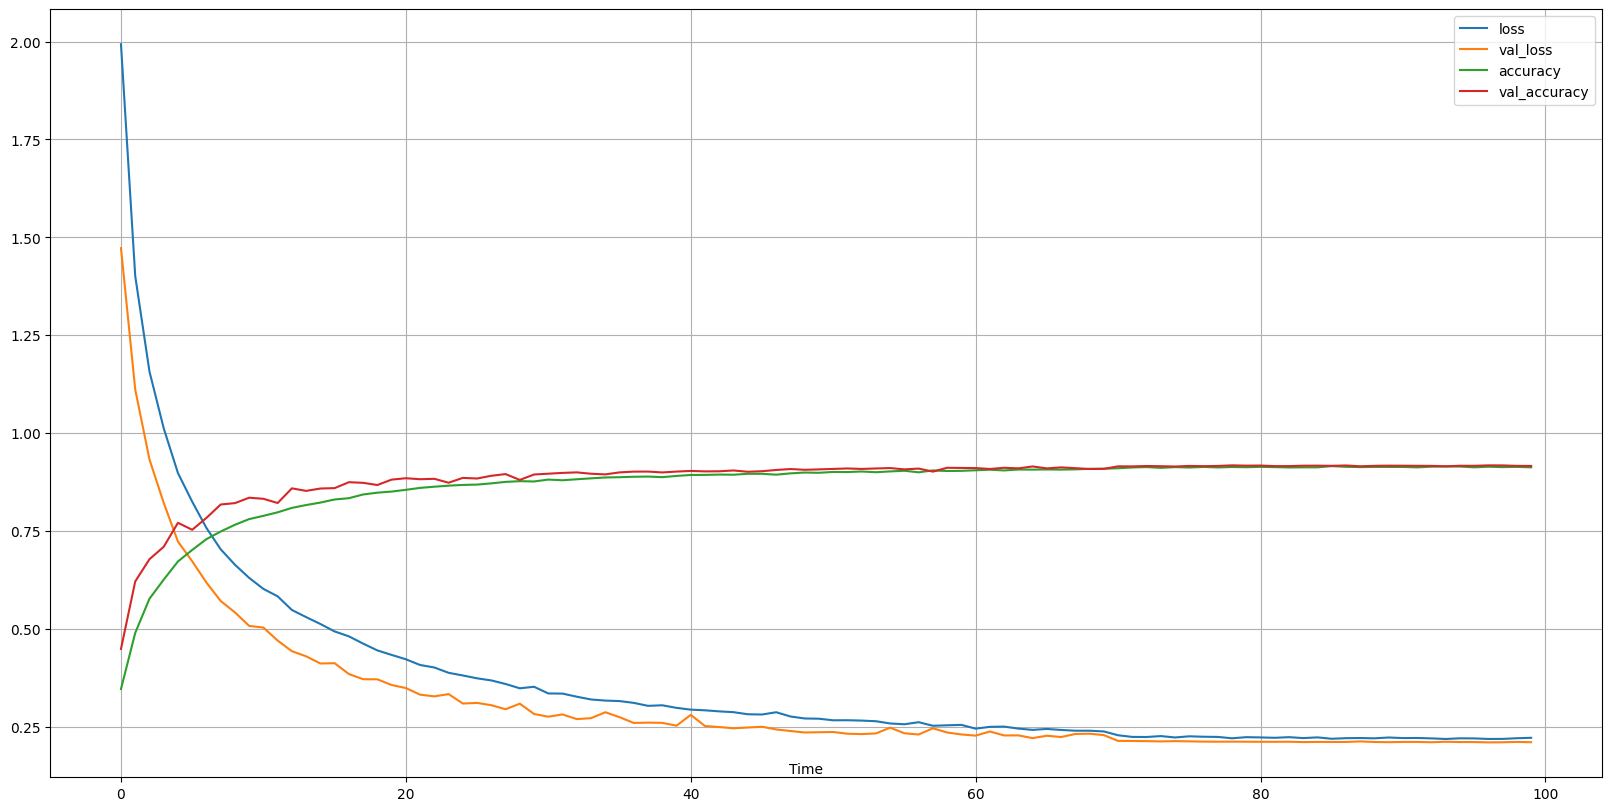

In [24]:
from crossai.visualization import plot_ts

plot_ts([
    history.history["loss"], history.history["val_loss"],
    history.history["accuracy"], history.history["val_accuracy"]
    ],
    labels=["loss", "val_loss", "accuracy", "val_accuracy"])

Confusion Matrix for more Insight

267/267 [==============================] - 1s 2ms/step


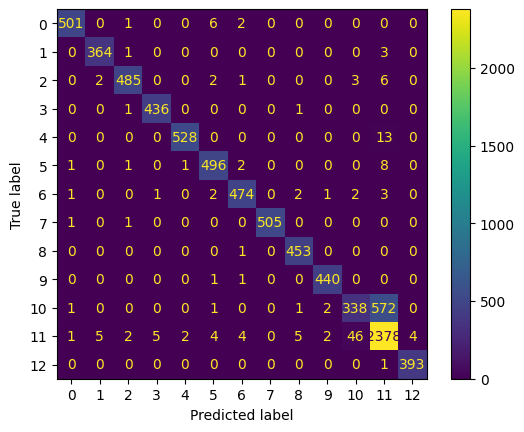

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(cnn1d.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot()

### Train a statistical model
Let's test the performance of a statistical model, like RandomForest

#### Prepare Data
Reducing the third dimension by flattening the timesteps for each axis

In [26]:
# flatten -> (instances, timesteps * axes)
X_train_flatten = X_train.reshape(X_train.shape[0], -1)
X_test_flatten = X_test.reshape(X_test.shape[0], -1)

X_test_flatten.shape, X_test_flatten.shape

((8521, 400), (8521, 400))

Train a RandomForest classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
model.fit(X_train_flatten, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

#### Make predictions

In [28]:
y_pred_probs = model.predict_proba(X_test_flatten)
predictions = model.predict(X_test_flatten)

##### Plot Confusion Matrix

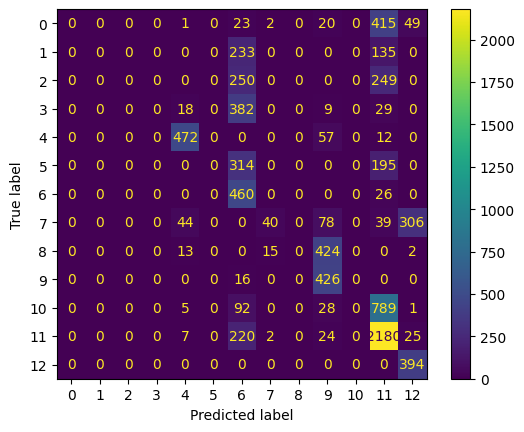

In [29]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

## Model Evaluation on Pilot Data

In [30]:
classes = list(le.classes_)
print(classes)

['01a', '01b', '01c', '01d', '02a', '02b', '02c', '03a', '03b', '03c', 'null', 'null_plus', 'rest']


Get path to pilot gesture instance

In [31]:
eval_instance_path = config["SINGLE_INSTANCE_EVALUATION_DATA_PATH"]

Load again in Tabular-like format, but this time the pilot data

In [32]:
import crossai.performance.loader as cpl

# load evaluation object by providing the path to the folder
# containing the data, the baseline label and the label mapping
cai_eval_tab = cpl.csv_loader(eval_instance_path, classes, delimiter=',')

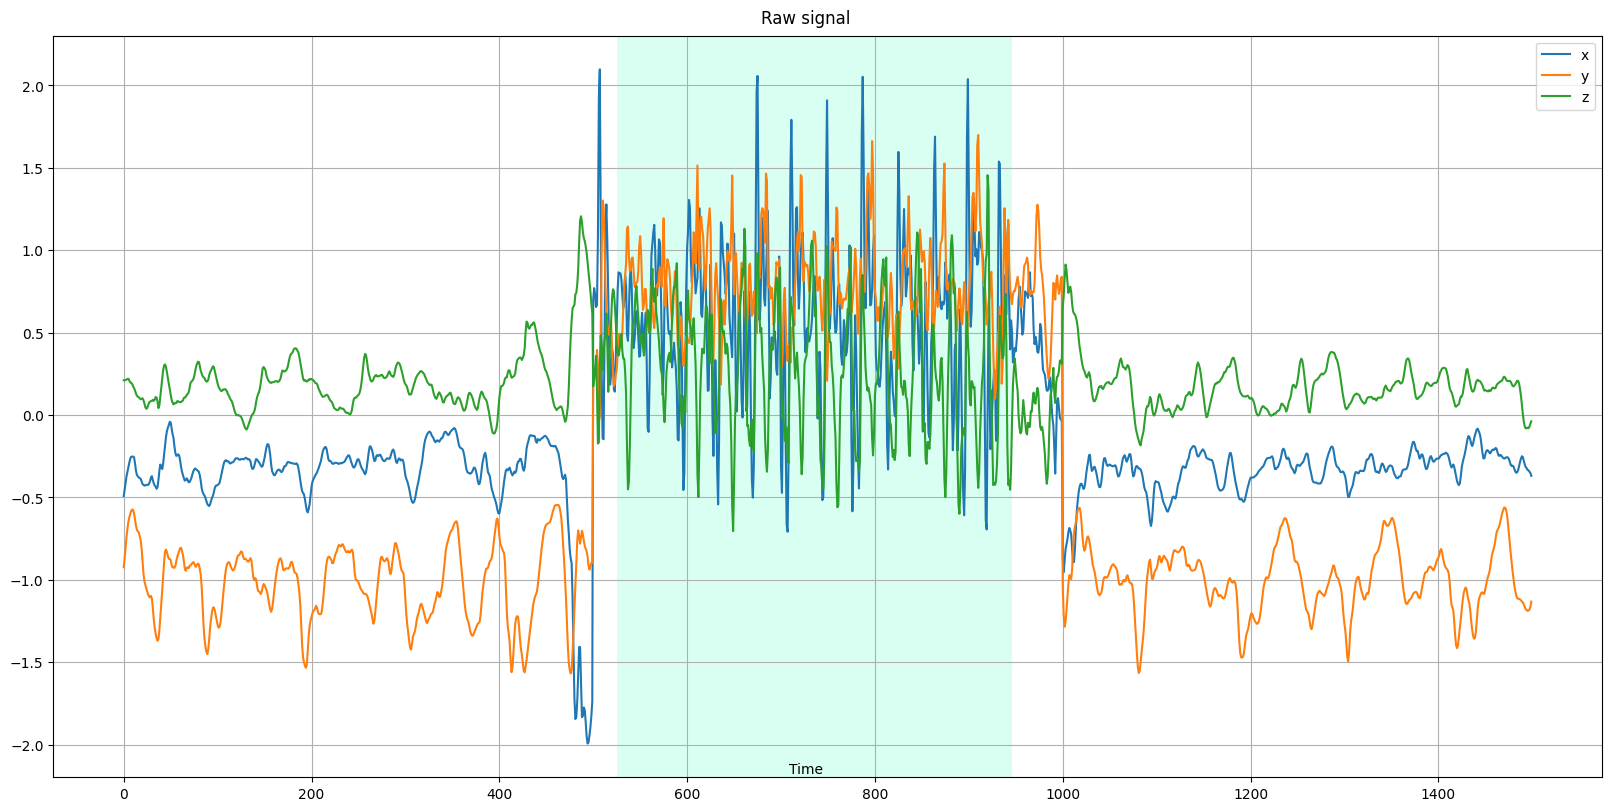

In [33]:
from crossai.visualization import plot_ts

plot_ts(
    data=cai_eval_tab.data[0:3],
    title="Raw signal",
    labels=["x","y","z"],
    segments=[[525,946,"aquamarine"]]
)

Perform similar processing as with train data by passing pilot instance through the same pipeline

In [34]:
pipe.transform(cai_eval_tab)

Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.00 seconds to transform.


Check Shape Compatibility

In [35]:
print(cai_eval_tab.data.shape)

(58, 50, 8)


#### Perform Pilot Evaluation

In [36]:
from crossai.performance.pilot_evaluation import evaluate

results = evaluate(
    model=cnn1d,
    data=cai_eval_tab.data,
    labels=cai_eval_tab.labels,
    repeats=2
)

Different Metrics from the evaluation

In [41]:
print("mean_predictions: ", results["mean_pred"])
print("STD:", results["std"])
print("Variance:", results["variance"])
print("Entropy: ", results["entropy"])
print("Predicted Classes: ", results["class"])

Count Insertions, deletions, substitutions and corrects

In [42]:
print("Y_eval: ", cai_eval_tab.labels)
print("Y_pred: ", results["class"])

print("Insertions: ", results["insertions"])
print("Deletions: ", results["deletions"])
print("Substitutions: ", results["substitutions"])
print("Corrects: ", results["correct"])

#### Plot section

Plots the probability of each instance being a specific gesture with respect to time

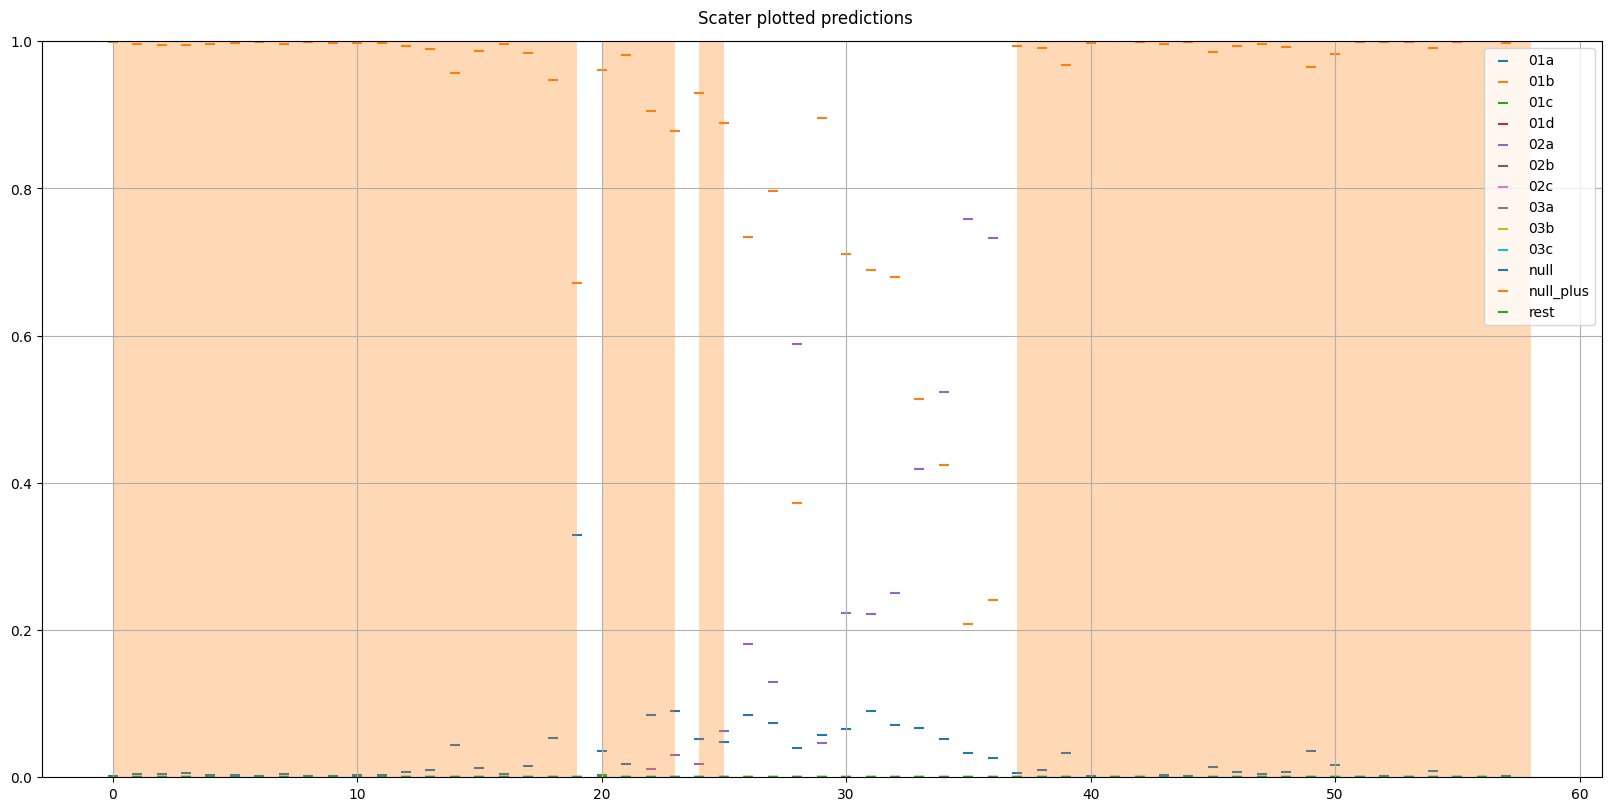

In [39]:
from crossai.visualization import plot_predictions

plot_predictions(results["mean_pred"],
                 title="Scater plotted predictions",
                 labels=list(le.classes_),
                 save_path=None,
                 show=True,
                 s=50,
                 color_threshold=0.9)

#### Batch pilot eval demo
Evaluate model on batch pilot data and save results

In [40]:
from crossai.performance.batch_pilot_evaluation import batch_evaluate

batch_evaluate(
    modality='tabular',
    model=cnn1d,
    folder=config["BATCH_EVALUATION_DATA_PATH"],
    classes=classes,
    pipeline=pipe,
    save_path=config["EVALUATION_SAVE_PATH"],
    per_window=False,
    repeats=2
)

Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.01 seconds to transform.
4/4 [==============================] - 0s 31ms/step
Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.01 seconds to transform.
3/3 [==============================] - 0s 45ms/step
Transformer MagnitudeExtractor took 0.00 seconds to transform.
Transformer MultiAxisSlidingWindow took 0.01 seconds to transform.
Transformer Scaler took 0.00 seconds to transform.
Transformer AxisToModelShape took 0.01 seconds to transform.
2/2 [==============================] - 0s 90ms/step
